In [40]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
import pandas as pd
import functools
from scipy.stats import norm
from random import random

In [41]:
data2 = pd.read_csv('puntosguia4.csv',sep = ';', decimal = ',', names = ['X', 'Y' ])
dataYsup = pd.read_csv('errores superiores.csv',sep = ';', decimal = ',', names = ['X', 'datasup'])
dataYinf = pd.read_csv('errores inferiores.csv',sep = ';', decimal = ',', names = ['X', 'datainf'])

In [42]:
data2Ysup = dataYsup.sort_values('X')
data2Yinf = dataYinf.sort_values('X')
# este codigo es porque se habian mezclado algunos valores y no estaban ordenados, en el grafico del error
# no iba a dar correctamente

Si quiero obtener las barras de error, los data2Ysup e data2Yinf me dan los valores donde terminan las barras de error, no su ancho, por lo tanto en el caso del error Y superior debo hacer: data2Ysup - data2 e insertar esos valores en una lista, al reves para el error Y inferior.

In [43]:
# Los paso a un array
data = np.array(data2)
Ysup = np.array(data2Ysup)
Yinf = np.array(data2Yinf)

In [44]:
errYsup = []
errYinf = []
for i in range(len(data)):
    x = Ysup[i][1] - data[i][1]
    y = data[i][1] - Yinf[i][1]
    errYsup.append(x)
    errYinf.append(y)


In [45]:
# errYsup?
# errYinf?

In [121]:
# Por si queremos usar los datos de magnitud y phi por separado
dataX = []
dataY = []
for i in range(len(data)):
    dataX.append(data[i][0])
    dataY.append(data[i][1])
# Pero trabajar con data2['X'] y data2['Y'] funciona bien igual

Text(0, 0.5, 'Phi')

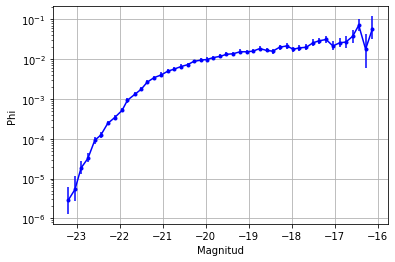

In [122]:
plt.plot(data2['X'], data2['Y'], c = 'blue')
plt.errorbar(data2['X'], data2['Y'], fmt = '.', yerr= (errYinf, errYsup), c = 'blue')
# yerr interpreta como las longitudes de las barras de error, primero van las de error inferior y luego la superior
plt.yscale('log')
plt.grid()
plt.xlabel('Magnitud')
plt.ylabel('Phi')

Quiero ajustar los puntos, para eso utilizamos la funcion de Schechter:
$\Phi(M) = 0.4 * ln(10) * \Phi^* * 10^{-0.4(M-M^*)(\alpha + 1)} * exp (-10^{-0.4 * (M - M^*)})$

Esta formula esta corregida respecto a la que se presenta en la guia, para que funcione el ajuste.

In [123]:
def Schechter(phi_est, M, alpha, M_est):
#     M son los valores de magnitud
#  phi_est, M_est y alpha son los parametros
    Funcion = []
    M0 = np.array(M)
    for i in range(len(M)):
        a = (-0.4) * (M0[i]-M_est) * (alpha+1) 
        b = (-0.4) * (M0[i]-M_est)
        
        phi = 0.4 * np.log(10) * (phi_est) * (10**a) * np.exp(-10**b)
        
        Funcion.append(phi)
    
    return(Funcion)

In [124]:
A = Schechter(1.46E-2, data2['X'], -1.20, -20.83)

In [125]:
# A?
# Es una lista, para el plot debo pasarlo a un array

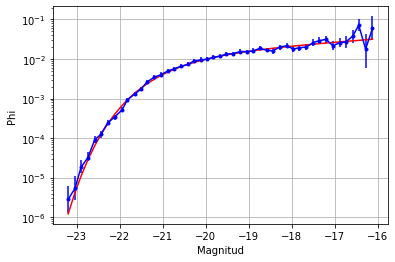

In [126]:
# Vemos el plot de los puntos con su error y el ajuste
plt.plot(data2['X'], np.array(A), color = 'red')
plt.plot(data2['X'], data2['Y'], c = 'blue')
plt.errorbar(data2['X'], data2['Y'], fmt = '.', yerr= (errYinf, errYsup), c = 'blue')
plt.yscale('log')
plt.grid()
plt.ylabel('Phi')
plt.xlabel('Magnitud')
plt.show()

$Metodo del Gradiente Descendiente$

Vamos a calcular la funcion del gradiente, esta es:

$\vec{a}_{new} = \vec{a}_{old} + \eta * \nabla\chi^2(\vec{a}_{old})$

Donde en el gradiente del $\chi^2$ debemos derivar a la funcion de Schechter respecto de los parametros y $ \beta$ es el tamaño del paso.
Defino primero la varianza:

In [52]:
for i in range (len(data)):
    S = (np.array(errYsup) + np.array(errYinf))

In [53]:
# s?

In [54]:
def chi2(phi_est, M_est, alpha, sigma=S, M = data2['X'], F = data2['Y']):
#     F son los valores de los datos de phi de data2
    chi = 0
    f_model = Schechter(phi_est, M, alpha, M_est)
    for i in range(len(M)):
        chi= chi + ((F[i] - f_model[i]) / sigma[i] )**2
        
    return(chi)

In [55]:
chi2(phi_est = 0.0146, M_est = -20.83, alpha=-1.2) 
#valores de Blanton

6.358529661215617

In [56]:
chi2(phi_est = 0.0147, M_est = -20.84, alpha = -1.21) 
# Probamos otros valores

6.797988099885424

Para ver como varia el $\chi^2$ en varias tajadas del plano, variamos 2 parametros dentro de un rango dejando un tercero costante, con un codigo de colores veremos el donde puede encontrarse el minimo del $\chi^2$

In [57]:
N = 100
# El valor que dejo fijo es de los parametros de Blanton
_X = np.linspace(0.0004, 0.025,N)  #phi
_Y = np.linspace(-21.2, -20.2,N)  #M
_W = np.linspace(-1.5, -0.9,N)  #alpha
_Z1 = np.zeros((N,N)) #matrices
_Z2 = np.zeros((N,N))
_Z3 = np.zeros((N,N))

for ix,x in enumerate(_X):
    for iy,y in enumerate(_Y):
        _Z1[iy,ix]=chi2(x, y, alpha=-1.2)

for ix,x in enumerate(_X):
    for iw,w in enumerate(_W):
        _Z2[iw,ix]=chi2(x, M_est = -20.83, alpha = w)
        
for iy,y in enumerate(_Y):
    for iw,w in enumerate(_W):
        _Z3[iw,iy]=chi2(phi_est = 0.0146, M_est = y, alpha = w)

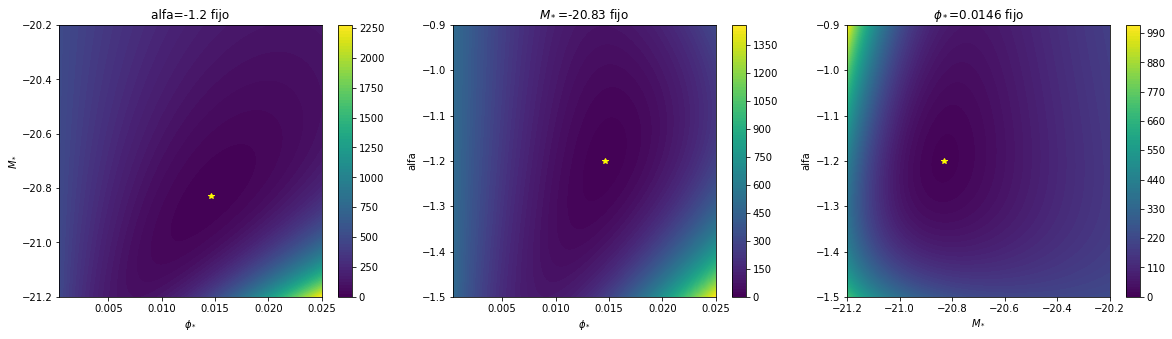

In [58]:
#Hacemos los plots de parametro vs parametro
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.contourf(_X,_Y,_Z1,100)
plt.colorbar()
plt.plot(0.0146, -20.83, '*', color='yellow')
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')
plt.title('alfa=-1.2 fijo')

plt.subplot(1,3,2)
plt.contourf(_X,_W,_Z2,100)
plt.colorbar()
plt.plot(0.0146, -1.2, '*', color='yellow')
plt.xlabel('$\phi_*$')
plt.ylabel('alfa')
plt.title('$M_*$=-20.83 fijo')

plt.subplot(1,3,3)
plt.contourf(_Y,_W,_Z3,100)
plt.colorbar()
plt.plot(-20.83, -1.2, '*', color='yellow')
plt.xlabel('$M_*$')
plt.ylabel('alfa')
plt.title('$\phi_*$=0.0146 fijo')

plt.show()

La estrella amarilla simboliza el valor de los parámetros de Blanton y se nota que el centro de las zonas más oscuras (mínimo) están centradas alrededor de esos valores. Alejandose de estos, la función $\chi^2$ empieza a aumentar su valor.

Vamos a calcular el gradiente de chi2, para eso vamos a definir 3 funciones que seran las derivadas de la funcion de Schechter de sus 3 parametros: $M^*, \phi^*  , \alpha$

In [76]:
# Por sencillez voy a llamar los datos de las magnitudes y los phi de la siguiente forma:
M = data2['X']
phi = data2['Y']
log = np.log
exp = np.exp

In [68]:
# M?

In [77]:
def derivada_dM_dphi_est(M, phi_est, M_est, a):
    #derivada del modelo respecto phi_estrella
#     a = alpha, del parametro de Blanton
    lista=[]
    for i in range(len(M)):
        y=0.4 * log(10) * (10**(-0.4*(M[i]-M_est)*(a+1))) * exp(-10**(-0.4*(M[i]-M_est)))
        lista.append(y)
    return lista

In [78]:
def derivada_dM_dM_est(M, phi_est, M_est, a):           #derivada del modelo respecto M0
    lista=[]
    for i in range(len(M)):
        #derivada:
        A = 0.4 * log(10) * phi_est
        B = log(10) * (10**(-0.4*(M[i]-M_est)*(a+1))) * 0.4 * (a+1) * exp(-10**(-0.4*(M[i]-M_est)))
        C = (10**(-0.4*(M[i]-M_est)*(a+1))) * exp(-10**(-0.4*(M[i]-M_est))) * 0.4 * log(10) * (10**(-0.4*(M[i]-M_est)))
        y= A * (B - C)
        lista.append(y)
    return lista


In [79]:
def derivada_dM_da(M, phi_est, M_est,a):            #derivada del modelo respecto a
    lista=[]
    for i in range(len(M)):
        y= 0.4 * log(10) * phi_est * log(10) * (10**(-0.4*(M[i]-M_est)*(a+1))) * (-0.4) * (M[i]-M_est) * exp(-10**(-0.4*(M[i]-M_est))) #derivada
        lista.append(y)
    return lista

In [80]:
def gradiente(M, phi,phi_est,M_est,a,sigma=S):   #gradiente de chi-cuadrado
    dchi_dphi_est=0
    dchi_dM_est=0
    dchi_da=0
    f_model = Schechter(phi_est, M, a, M_est)
    dphi_est = derivada_dM_dphi_est(M, phi_est, M_est, a)
    dM_est = derivada_dM_dM_est(M, phi_est, M_est, a)
    da = derivada_dM_da(M, phi_est, M_est, a)
    
    for i in range(len(M)):
        dchi_dphi_est= dchi_dphi_est - 2 * (f[i] - f_model[i]) / (sigma[i]**2) * dphi_est[i]
        dchi_dM_est= dchi_dM_est - 2 * (f[i] - f_model[i]) / (sigma[i]**2) * dM_est[i]
        dchi_da= dchi_da - 2 * (f[i] - f_model[i]) / (sigma[i]**2) * da[i]

    return(np.array([dchi_dphi_est, dchi_dM_est, dchi_da]))  #vector gradiente

In [81]:
gradiente(M,f,phi_est = 0.0146, M_est = -20.83, a=-1.2) #valores de Blanton

array([43.65928109, -1.21255962, -4.30343677])


Gradiente descendiente:
Recordar:

$$ \vec{a_{new}}=\vec{a_{old}} - \eta \vec{\nabla \chi^2} (\vec{a_{old}}) $$
Como $\vec{\nabla \chi^2}$ tiene valores de módulos muy elevados, esto influye directamente en el "salto" de los parámetros, y recordando que los parámetros $\phi_*$, $M_*$ y $\alpha$ son de distintos órdenes de magnitud, es por eso que se los multiplica a los saltos por un factor.

Tomando $\eta=0.05$ y multiplicando a $\phi_*$ por el factor $10^{-6}$, a $M_*$ por $10^{-2}$ y a $\alpha$ por $10^{-3}$ se encuentra que el método se acerca bastante a los valores esperados, por lo que se toman estos valores.

Para tratar de explicar estos valores se analiza la multiplicación ($\eta$ . factor) para cada parámetro. Se descubre que la diferencia de ordenes de magnitud entre el valor esperado y ($\eta$ . factor) es de 5 órdenes para los parámetros $M_*$ y $\alpha$, y de 6 ordenes para $\phi_*$.

Esto indica que los saltos son mucho más chicos (entre 5 y 6 ordenes de magnitud) que los valores de los parámetros. La diferencia que se nota de ordenes entre $\phi_*$ y el resto de parámetros podría estar relacionado con el rango elegido en donde se mueve $\phi_*$.

In [97]:
def grad_desc(M,f, eta, n_pasos):
#     Esto es parecido a la caminata que hicimos anteriormente
    grad=np.array([0,0,0])
    while grad.any() < (1.e-8):
        #parametros iniciales - le doy un rango cercano a los esperados
        fi0_old=np.random.uniform(0.0004, 0.025)
        M0_old=np.random.uniform(-21.2, -20.2) 
        a_old=np.random.uniform(-1.5, -0.9)
        
        grad= gradiente(M, f, fi0_old, M0_old, a_old)
    
    #listas donde guardo los pasos - guardo los valores iniciales
    camino_fi0= [fi0_old]
    camino_M0= [M0_old]
    camino_a= [a_old]
    
    for i in range(1,n_pasos):
        fi0_old = fi0_old - eta * (grad[0]) * (10**-6)
        M0_old = M0_old - eta * (grad[1]) * (10**-2)
        a_old = a_old - eta * (grad[2]) * (10**-3)
        
        grad= gradiente(M,f,fi0_old, M0_old, a_old)
        
        camino_fi0.append(fi0_old)
        camino_M0.append(M0_old)
        camino_a.append(a_old)
        
    return (camino_fi0, camino_M0, camino_a)

Se define la función con $\eta$=0.05 y 50 pasos, después se muestran los últimos valores que son los esperados

In [98]:
j=grad_desc(M,f,eta=0.05, n_pasos=50)

In [99]:
# j?
# len(j[0])

In [100]:
fi0_final=j[0][-1]
M0_final=j[1][-1]
a_final=j[2][-1]
print('El valor final para fi0:', fi0_final)
print('El valor final para M0:', M0_final)
print('El valor final para a:', a_final)

El valor final para fi0: 0.013916986746259245
El valor final para M0: -20.855521833019868
El valor final para a: -1.2197894711881154


Se puede ver que los valores encontrados son similares a los de Blanton et al. (2001): $\phi_*$=0.0146, $M_*$=-20.83 y $\alpha$=-1.2.

Se realiza un gráfico de parámetro vs parámetro para ver los caminos:

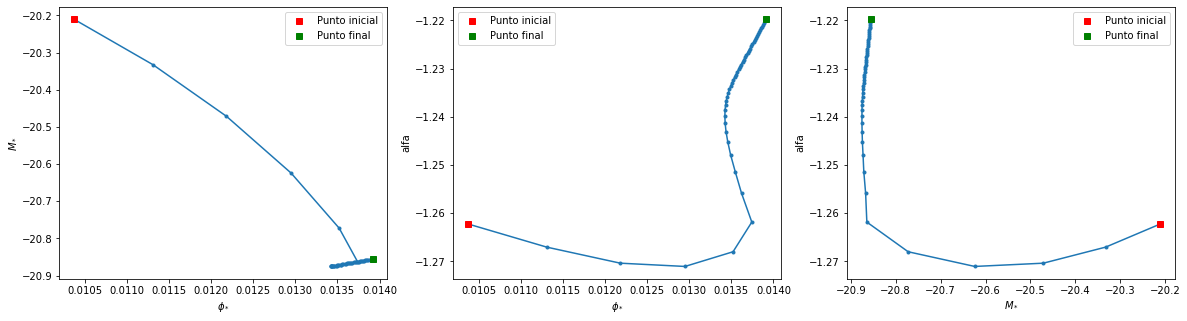

In [101]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(j[0], j[1], marker='.')
plt.plot(j[0][0], j[1][0], 's', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[0][-1], j[1][-1], 's', color='green', label='Punto final') #parametros finales
plt.legend(loc='best')
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')

plt.subplot(1,3,2)
plt.plot(j[0], j[2], marker='.')
plt.plot(j[0][0], j[2][0], 's', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[0][-1], j[2][-1], 's', color='green', label='Punto final') #parametros finales
plt.legend(loc='best')
plt.xlabel('$\phi_*$')
plt.ylabel('alfa')

plt.subplot(1,3,3)
plt.plot(j[1], j[2], marker='.')
plt.plot(j[1][0], j[2][0], 's', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[1][-1], j[2][-1], 's', color='green', label='Punto final') #parametros finales
plt.legend(loc='best')
plt.xlabel('$M_*$')
plt.ylabel('alfa')

plt.show()

Se compara el mismo gráfico con la grilla realizada al principio para analizarlo mejor:

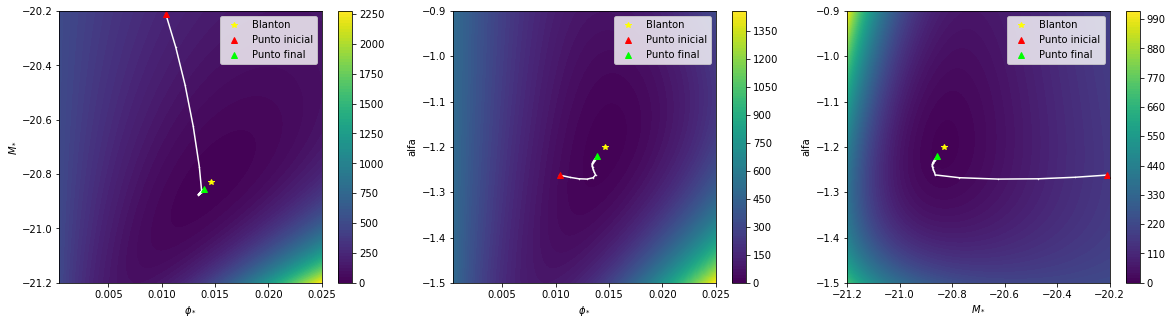

In [102]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.contourf(_X,_Y,_Z1,100)
plt.colorbar()
plt.plot(0.0146, -20.83, '*', color='yellow', label='Blanton')
plt.plot(j[0], j[1], marker='.',markersize=1, color='white')
plt.plot(j[0][0], j[1][0], '^', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[0][-1], j[1][-1], '^', color='lime', label='Punto final') #parametros finales
plt.legend(loc='best')
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')

plt.subplot(1,3,2)
plt.contourf(_X,_W,_Z2,100)
plt.colorbar()
plt.plot(0.0146, -1.2, '*', color='yellow', label='Blanton')
plt.plot(j[0], j[2], marker='.',markersize=1, color='white')
plt.plot(j[0][0], j[2][0], '^', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[0][-1], j[2][-1], '^', color='lime', label='Punto final') #parametros finales
plt.legend(loc='best')
plt.xlabel('$\phi_*$')
plt.ylabel('alfa')

plt.subplot(1,3,3)
plt.contourf(_Y,_W,_Z3,100)
plt.colorbar()
plt.plot(-20.83, -1.2, '*', color='yellow', label='Blanton')
plt.plot(j[1], j[2], marker='.',markersize=1, color='white')
plt.plot(j[1][0], j[2][0], '^', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[1][-1], j[2][-1], '^', color='lime', label='Punto final') #parametros finales
plt.legend(loc='best')
plt.xlabel('$M_*$')
plt.ylabel('alfa')

plt.show()


Se ve como el valor inicial está alejado de las zonas más oscuras, y luego tiende a acercarse a ella, acercándose al mismo tiempo a los valores que encontró Blanton.

Luego, se ve si los valores encontrados ajustan con el modelo a los datos medidos:

In [107]:
Y = Schechter(phi_est=j[0][-1], M = data2['X'], alpha = j[2][-1], M_est = j[1][-1])

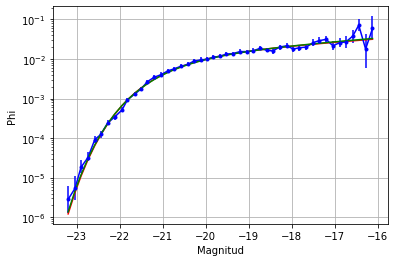

In [127]:
plt.plot(data2['X'], np.array(A), color = 'red', label = 'Valores de Blanton')
plt.plot(data2['X'], data2['Y'], c = 'blue', label = 'Datos')
plt.errorbar(data2['X'], data2['Y'], fmt = '.', yerr= (errYinf, errYsup), c = 'blue')
plt.plot(data2['X'],np.array(Y), color='green', label='Valores obtenidos por GD')
plt.yscale('log')
plt.grid()
plt.ylabel('Phi')
plt.xlabel('Magnitud')
plt.show()

Se puede ver como los valores encontrados por el método del Gradiente Descendiente ajustan bien a los datos, dando un ajuste muy parecido al de Blanton. Es un método efectivo para la optimización de parámetros.

Por último, para ver como se comporta el método en general se realizan varios caminos sorteando 4 veces más la función 'grad_desc':

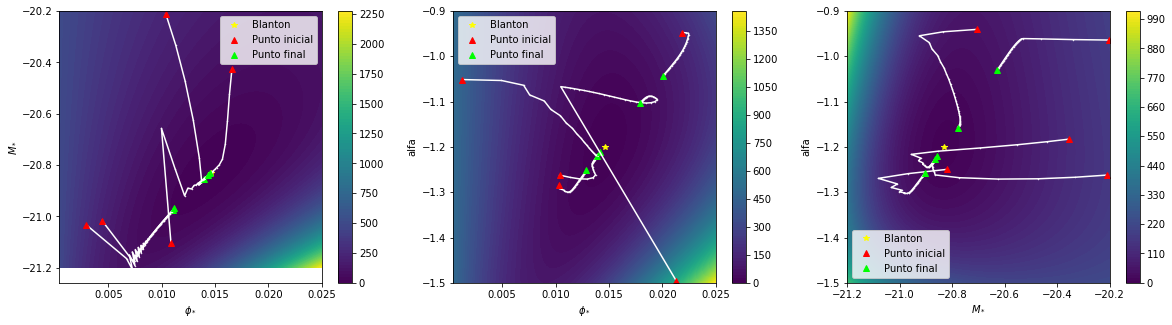

In [128]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.contourf(_X,_Y,_Z1,100)
plt.colorbar()
plt.plot(0.0146, -20.83, '*', color='yellow', label='Blanton')
plt.plot(j[0], j[1], marker='.',markersize=1, color='white')
plt.plot(j[0][0], j[1][0], '^', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[0][-1], j[1][-1], '^', color='lime', label='Punto final') #parametros finales
for k in range(4):
    k=grad_desc(M,f,eta=0.05, n_pasos=50)
    plt.plot(k[0], k[1], marker='.',markersize=1, color='white')
    plt.plot(k[0][0], k[1][0], '^', color='red')
    plt.plot(k[0][-1], k[1][-1], '^', color='lime')
plt.legend(loc='best')
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')

plt.subplot(1,3,2)
plt.contourf(_X,_W,_Z2,100)
plt.colorbar()
plt.plot(0.0146, -1.2, '*', color='yellow', label='Blanton')
plt.plot(j[0], j[2], marker='.',markersize=1, color='white')
plt.plot(j[0][0], j[2][0], '^', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[0][-1], j[2][-1], '^', color='lime', label='Punto final') #parametros finales
for k in range(4):
    k=grad_desc(M,f,eta=0.05, n_pasos=50)
    plt.plot(k[0], k[2], marker='.',markersize=1, color='white')
    plt.plot(k[0][0], k[2][0], '^', color='red')
    plt.plot(k[0][-1], k[2][-1], '^', color='lime')
plt.legend(loc='best')
plt.xlabel('$\phi_*$')
plt.ylabel('alfa')

plt.subplot(1,3,3)
plt.contourf(_Y,_W,_Z3,100)
plt.colorbar()
plt.plot(-20.83, -1.2, '*', color='yellow', label='Blanton')
plt.plot(j[1], j[2], marker='.',markersize=1, color='white')
plt.plot(j[1][0], j[2][0], '^', color='red', label='Punto inicial') #parametros iniciales
plt.plot(j[1][-1], j[2][-1], '^', color='lime', label='Punto final') #parametros finales
for k in range(4):
    k=grad_desc(M,f,eta=0.05, n_pasos=50)
    plt.plot(k[1], k[2], marker='.',markersize=1, color='white')
    plt.plot(k[1][0], k[2][0], '^', color='red')
    plt.plot(k[1][-1], k[2][-1], '^', color='lime')
plt.legend(loc='best')
plt.xlabel('$M_*$')
plt.ylabel('alfa')

plt.show()

Se puede ver como en todos los casos a pesar de que los caminos empiezan en lugares distintos, siempre tienden a acercarse a los valores mínimos (zonas más oscuras).

$Conclusiones$

En este trabajo se logró ajustar la función de Schechter a la función de luminosidad de galaxias obtenida por Blanton et al. 2001 por medio del método del Gradiente Descendiente. Este método es un algoritmo de optimización iterativo de primer orden para encontrar un mínimo local de una función diferenciable. Se parte de un rango de valores y el método los mejora, encontrando el mínimo de la función $\chi^2$.

Los valores obtenidos para los parámetros son similares a los de Blanton y ajustan bien a los datos.